In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import sklearn.metrics as metrics
import torch
from ray import air, tune
from ray.air import session

import flippers
from flippers.models import SnorkelModel

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [5]:
from examples.utils import load_wrench_dataset, MetricsUtil, datasets, dataset_to_metric

In [6]:
Best_Configs = {}
Results = {}
Metrics = {}

In [7]:
ray.init()

2023-05-29 14:39:17,519	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.10.9
Ray version:,2.3.1


In [8]:
%%time

# Define a search space and initialize the search algorithm.
search_space = {
    "learning_rate": tune.grid_search([1e-2, 5e-3, 1e-3]),
    "num_epochs": tune.grid_search([10, 50, 100, 200]),
    "k": tune.grid_search([0 , 1e-2, 1e-3]),
    "prec_init": tune.grid_search([0.3, 0.5, 0.7]),
}

for dataset in datasets:
    data, weak_labels, polarities = load_wrench_dataset(dataset)
    train, dev, test = data
    L_train, L_dev, L_test = weak_labels

    y_dev = dev["label"].values.astype(int)
    y_test = test["label"].values.astype(int)
    class_balances = list(
        dev["label"].astype(int).value_counts(normalize=True).sort_index()
    )
    
    del train
    del dev
    del test
    del data
    del weak_labels
    
    MetricsDev = MetricsUtil(L=L_dev, y_true=y_dev)
    # Wrap SnorkelModel in an objective function
    def objective(config):
        m = SnorkelModel(polarities=polarities, class_balances=class_balances)
        m.fit(L_train, **config)
        scores = MetricsDev.score(m, plots=False)  # Compute validation metrics
        scores["model"] = m
        session.report(scores)  # Report to Tune

    # Start a Tune run that maximizes metric on dev set
    tuner = tune.Tuner(
        tune.with_resources(objective, {"cpu": 8}),
        param_space=search_space,
        run_config=air.RunConfig(progress_reporter=tune.JupyterNotebookReporter()),
    )
    results = tuner.fit()

    metric = dataset_to_metric[dataset]
    best_result = results.get_best_result(metric=metric, mode="max")
    Best_Configs[dataset] = best_result.config
    Results[dataset] = results

    # m = SnorkelModel(polarities=polarities, class_balances=class_balances)
    # config = best_result.config
    # m.fit(L_train, **config)
    m = best_result.metrics["model"]
    
    Metrics[dataset] = MetricsUtil(L=L_test, y_true=y_test).score(m, plots=False)

Trial name,AUC,Accuracy,Average_Precision,Balanced_Accuracy,F1,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,model,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
objective_7492b_00000,0.707,0.785,0.508,0.612,0.385,2023-05-29_14-47-57,True,,d76ac74c98cd4024b5df9879e8d8fb87,"0_k=0,learning_rate=0.0100,num_epochs=10,prec_init=0.3000",LAPTOP,1,SnorkelModel(),127.0.0.1,4068,0.0662041,0.0662041,0.0662041,1685396877,0,,1,7492b_00000,0.00800991


2023-05-29 14:49:00,619	INFO tune.py:798 -- Total run time: 71.26 seconds (71.00 seconds for the tuning loop).


CPU times: total: 1min 14s
Wall time: 9min 41s


In [9]:
df = pd.DataFrame(Metrics)


# Formatting function to underline entries
def underline_entries(x):
    is_metric = x.index == dataset_to_metric[x.name]
    return ["text-decoration: underline" if v else "" for v in is_metric]


# Underlines the metrics used in the wrench benchmark
df.style.apply(underline_entries).format("{:.3f}")

,imdb,yelp,youtube,sms,spouse,cdr,commercial,tennis,basketball,census
F1,0.688,0.763,0.845,0.072,0.512,0.714,0.882,0.825,0.174,0.580
Average_Precision,0.699,0.776,0.908,0.138,0.391,0.667,0.934,0.787,0.117,0.651
AUC,0.708,0.770,0.866,0.500,0.802,0.858,0.975,0.884,0.527,0.821
Accuracy,0.708,0.739,0.868,0.846,0.911,0.770,0.928,0.875,0.549,0.817
Balanced_Accuracy,0.708,0.737,0.862,0.507,0.759,0.801,0.908,0.875,0.515,0.720


Results of other label models on wrench datasets : [[wrench]](https://arxiv.org/abs/2109.11377)

![wrench.png](wrench.png)

In [10]:
pd.DataFrame(Best_Configs)

,imdb,yelp,youtube,sms,spouse,cdr,commercial,tennis,basketball,census
learning_rate,0.01,0.001,0.005,0.01,0.001,0.001,0.010,0.01,0.01,0.001
num_epochs,10.00,50.000,10.000,200.00,10.000,200.000,50.000,10.00,200.00,10.000
k,0.01,0.001,0.010,0.01,0.000,0.000,0.001,0.00,0.00,0.001
prec_init,0.30,0.300,0.700,0.30,0.300,0.500,0.300,0.30,0.30,0.300


# Inspect best hyperparameter value per model

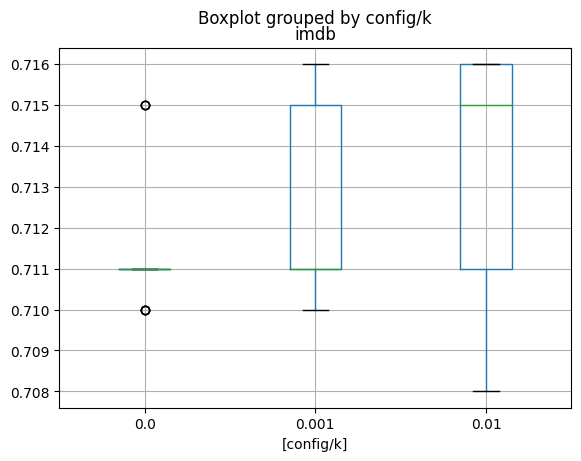

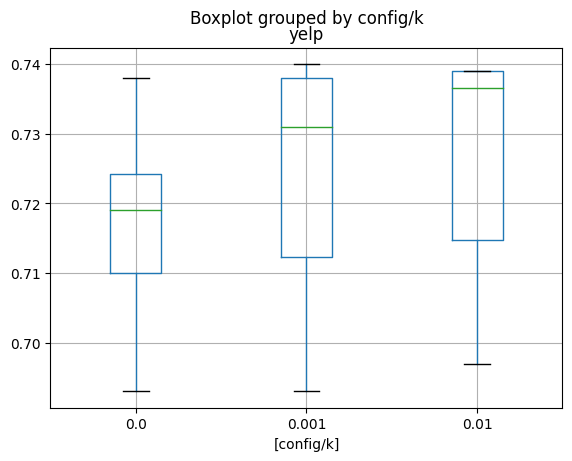

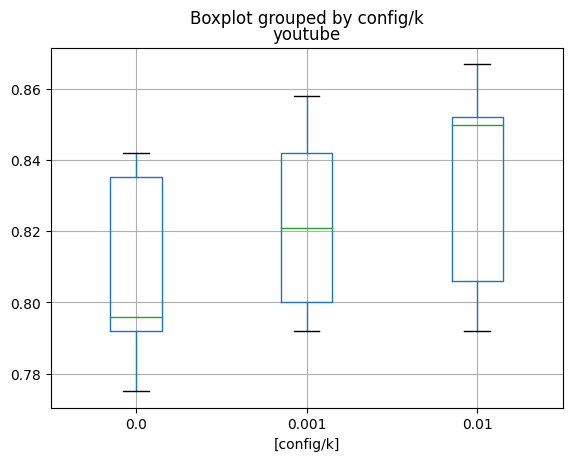

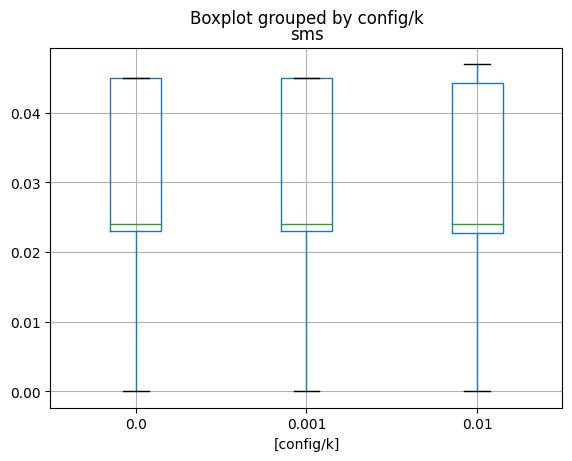

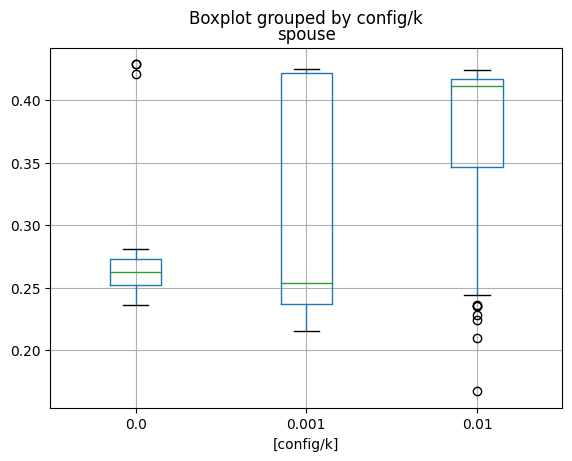

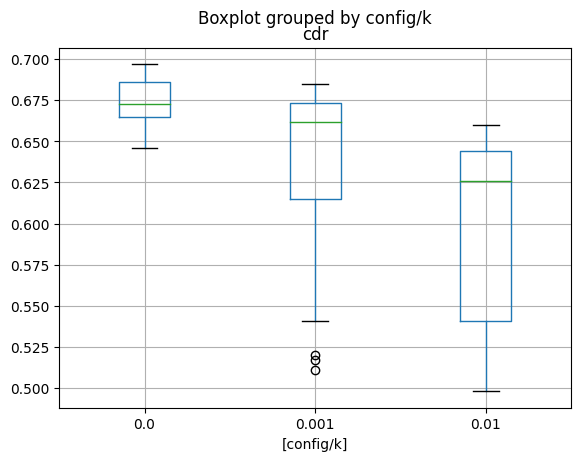

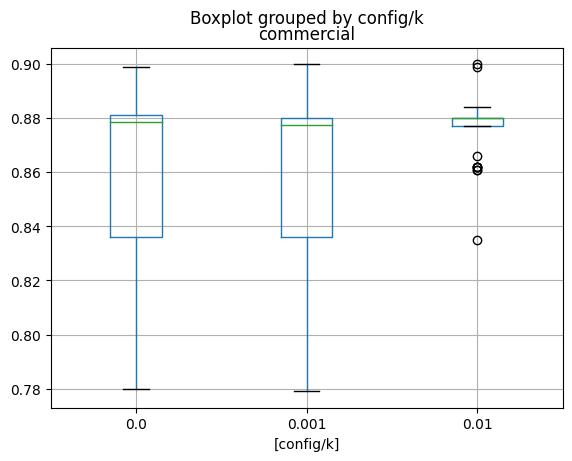

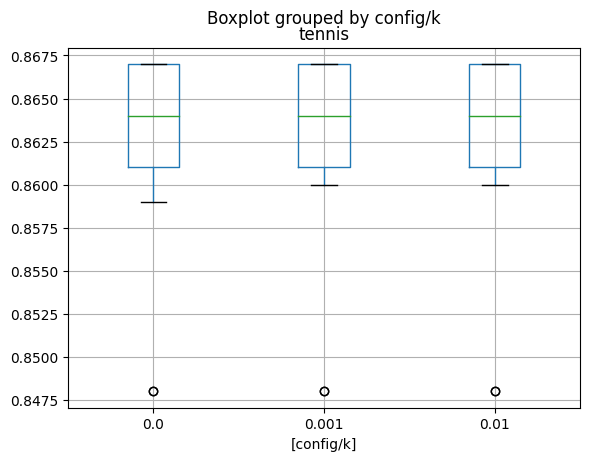

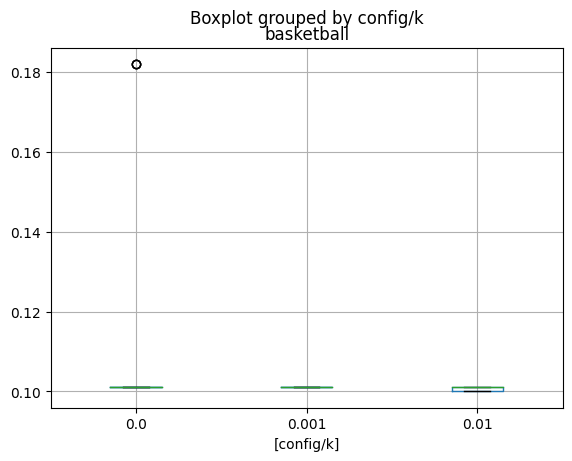

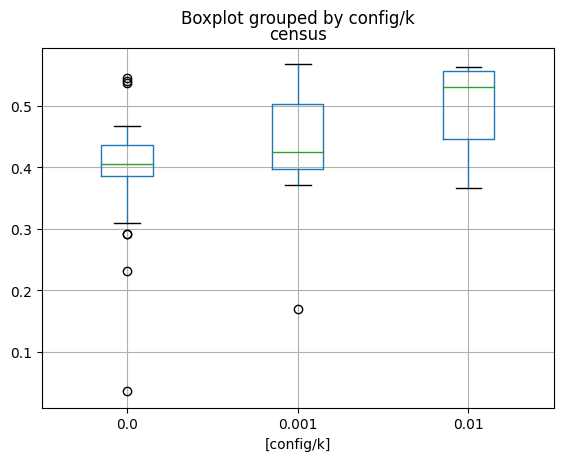

In [11]:
for dataset in datasets:
    grid = Results[dataset]
    grid = grid.get_dataframe()
    # grid = grid[grid["config/k"] == 0]
    hparam = "k"
    hparam = "config/" + hparam
    grid[[dataset_to_metric[dataset], hparam]].boxplot(by=hparam)
    plt.title(dataset)